In [61]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

###  1. Load Epinions Database

#### 1.1. Load the trust data

In [62]:
df = pd.read_csv('t_epinions.txt', delim_whitespace=True, header=None,\
             names=['u', 'v', 'trust'], dtype={'u':'str', 'v':'str', 'trust':'int'})

#### 1.2. Load raw Epinions and complete trust sampling based on the previous trust data

In [63]:
Ge = nx.read_edgelist('soc-Epinions1.txt', data = [('Sign', int)])
G = nx.from_pandas_edgelist(df, source='u', target='v', edge_attr='trust')
for e in Ge.edges: 
    if e not in G.edges:
        G.add_edge(*e,trust=np.random.uniform(0.5,1))
    else:
        G[e[0]][e[1]]['trust'] = np.random.uniform(0,0.5)

# Save graph to reload with a more powerful module
nx.write_gml(G,'epinions.gml')

In [64]:
g = gt.load_graph('epinions.gml', fmt='gml')
print(g.num_edges())

782680


### 2. Compute Eigentrust 

In [65]:
t_map = g.ep['trust']
g_eigen = gt.eigentrust(g,trust_map=t_map)

#### 2.1. Sample subgraph of 1490 nodes

In [66]:
cap = 1490
counter = 0
epsilon = 0.5
vfilt = g.new_vp('bool')
for v in g.vertices():
    if epsilon < np.random.uniform(0,1):
        counter += 1
        vfilt[v] = True
    if counter >= cap:
        break

In [67]:
subg = gt.GraphView(g, vfilt)
print(subg.num_vertices())

1490


#### 2.2. Retrieve (eigen)trust values for subgraph

In [68]:
counter = 0
number_of_nodes = subg.num_vertices()
eigen = subg.new_vp('float')
sub_eigen = np.empty((1, number_of_nodes))
pos_0 = subg.new_vp('vector<float>')
pos = gt.collection.data["as-22july06"].vp['pos']
for _,v in enumerate(g.vertices()):
    if vfilt[v]:
        counter += 1
        eigen[v] = g_eigen[v]
        sub_eigen[0][counter-1] = eigen[v]
        pos_0[v] = pos[v]

#### 2.4. Plot the subgraph w.r.t to (eigen)trust values

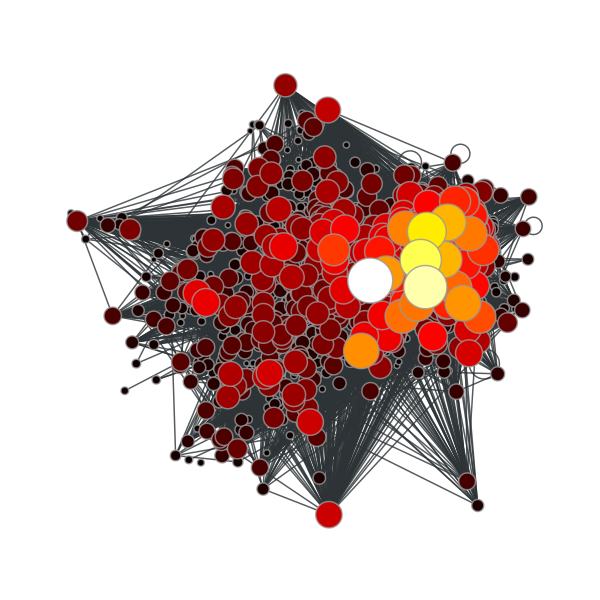

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1fa08d7910, at 0x7f1f9f367f10>

In [69]:
v_size = gt.prop_to_size(eigen, mi=5, ma=45)
gt.graph_draw(subg,pos=pos_0,vertex_size=v_size,\
              vertex_fill_color= eigen, vcmap=plt.cm.hot, vorder= eigen)

### 3. Evaluating Max_trust

#### 3.1. Import local module with tropical operations and algorithms

In [70]:
import tropical_module as tm

#### 3.2. Derive Adjacency Matrix and  set initial conditions

In [71]:
# Adjacency matrix
A = gt.adjacency(subg).toarray()
# Initial random vector
v = np.ones(A.shape[1]) / A.shape[1]
# Detecting strongly connected components
## Based on Seneta's observation on irreducibility,
## as per Equation (6) in our paper
B = tm.make_irreducible(A)
B = B / np.sum(B,axis=0)
B = tm.normal_form3(B)

#### 3.4 Obtain analytical benchmark and apply Max_Trust

In [72]:
v,W = np.linalg.eig(A) 
eig1 = np.argmax(v)
analytical = W[:,eig1]/np.sum(W[:,eig1])
max_trust = tm.max_trust(B,v,100)

#### 3.5. Compute distance between the analytical benchmark and Max_Trust/Eigentrust 

In [73]:
results = np.empty((3, number_of_nodes))
results[0] = analytical
results[1] = sub_eigen
results[2] = max_trust
norms_apr = {method: [np.abs(results[0]- results[n+1])] for n, method in zip(range(2), ['eigentrust', 'maxtrust'])}

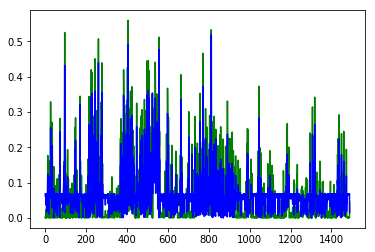

In [74]:
mt = norms_apr['maxtrust'][0]
mt = mt*100/mt.sum()
et = norms_apr['eigentrust'][0]
et = et*100/et.sum()
plt.plot(et, label='eigentrust', color='green')
plt.plot(mt, label='maxtrust', color='blue')

In [75]:
print('maxtrust variance:', mt.var(), 'eigentrust variance:', et.var())

maxtrust variance: 0.0036346460449359448 eigentrust variance: 0.008488044387251849
